# Part 3: Case study: binaural sound localisation

In [1]:
from brian2 import *
%matplotlib inline
prefs.codegen.target = 'numpy'

By default, Brian simulates everything in steps of 0.1ms. Here, we are modeling neurons in the auditory brain stem which are *very* fast and highly sensitive to small time differences in auditory signals. We therefore have to lower Brian's simulation time step:

In [2]:
defaultclock.dt = 0.02*ms

In [3]:
# A little plotting function to plot the spikes coming from the "periphery model"
def plot_periphery_model(sound_input, periphery_spikes, limits=None):
    fig, (ax_inp, ax_spikes) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1]})
    ax_inp.plot(sound_input.t/ms, sound_input.delayed_sound.T)
    ax_inp.spines['right'].set_visible(False)
    ax_inp.spines['left'].set_visible(False)
    ax_inp.spines['top'].set_visible(False)
    ax_inp.set_yticks([])

    spike_times = periphery_spikes.spike_trains()
    ax_spikes.plot(spike_times[0]/ms, np.ones(len(spike_times[0])), 'o')
    ax_spikes.plot(spike_times[1]/ms, np.zeros(len(spike_times[1])), 'o')
    ax_spikes.spines['left'].set_visible(False)	
    ax_spikes.spines['right'].set_visible(False)
    ax_spikes.spines['top'].set_visible(False)
    ax_spikes.set_yticks([])
    if limits is not None:
        ax_spikes.set_xlim(*[l/ms for l in limits])
    ax_spikes.set_xlabel('time (ms)')
    plt.tight_layout()

The sound that gets played is a pure tone at 440Hz, which gets translated into spiking activity at the periphery (i.e. cochlea of the ear). The exact timing of the sound depends on the distance of the sound to the two ears: if the sound comes directly from in front of the head ($\theta = 0$), it arrives at the same time at both ears. If it comes for example from the far right ($\theta = \frac{\pi}{2}$), it will arrive first at the right ear, and after the time it takes for the sound to travel the distance between the ears at the left ear. In our example below, we increase the value of $\theta$ constantly ($\frac{d\theta}{dt} = a$) (where $a$ is the "angular speed"), i.e. the sound source continously turns around the head. The mechanism to turn the sound into spikes is very simple, neurons are modeled as noisy leaky-integrate-and-fire neurons with the sound as its input (comparable to a current stimulation via an electrode). For simplicity, this is a dimensionless model, i.e. the $x$ variable is like a membrane potential but without units, it varies between 0 (instead of $E_L$) and 1 (instead of a threshold). The model has two neurons, one for each ear:

In [4]:
start_scope()

# Ears with moving sound source
sound_speed = 300*metre/second
interaural_distance = 20*cm # big head!
max_delay = interaural_distance / sound_speed
angular_speed = 2 * pi / second # 1 turn/second
tau_ear = 1*ms; sigma_ear = .1

eqs_ears = '''
dx/dt = (delayed_sound - x)/tau_ear+sigma_ear*(2./tau_ear)**.5*xi : 1 (unless refractory)
delayed_sound = 10*sin(2*pi*440*Hz*(t - delay)) : 1
delay = distance*sin(theta) : second
distance : second # distance to the centre of the head in time units
dtheta/dt = angular_speed : radian
'''
ears = NeuronGroup(2, eqs_ears, threshold='x>1', reset='x = 0',
                   refractory=2.5*ms, name='ears', method='euler')
ears.distance = [-.5 * max_delay, .5 * max_delay]
sound_input = StateMonitor(ears, "delayed_sound", record=True)
periphery_spikes = SpikeMonitor(ears)

run(1000*ms)

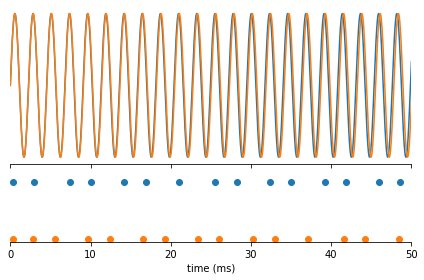

In [5]:
plot_periphery_model(sound_input, periphery_spikes, limits=(0*ms, 50*ms))

As you can see in the above plot, each neuron tends to spike once for each cycle of the sound (but sometimes misses a cycle due to the noisiness). If both neurons spike during the same cycle, they spike at almost the same time since the sound source is in front of the head.

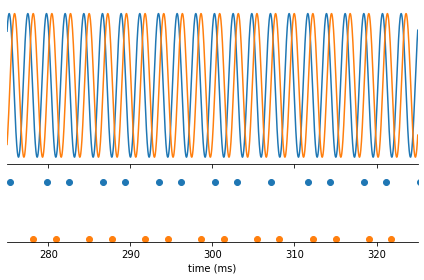

In [6]:
plot_periphery_model(sound_input, periphery_spikes, limits=(275*ms, 325*ms))

Later (as pictured above), the sound source is to the left of the head, so that the left (blue) neuron spikes slightly earlier than the right (orange) neuron.

We now take this model of our periphery and connect it to 30 neurons representing neurons in the brainstem. Each of these neurons gets inputs from the two ears, but each with different relative delays of the two inputs. I.e., one of the neurons will get the input from the left and right ears with the exact same timing they had at the periphery, whereas others will get one of the inputs delayed with respect to the other one. The neurons are again modeled as simplified (unitless) noisy leaky-integrate-and-fire neurons and are very fast ($\tau = 1$ms). This means that they act as *coincidence detectors*, they need to receive spikes from the two ears to arrive at almost exactly the same time to fire a spike. Due to the delay structure, this means that some neurons will detect when the neurons from the left and right ear fire simultaneously, while others will detect when one of the neurons fires at a certain time before the other – due to the delay, these two spikes will arrive at the same time. Putting this all together means that by looking at which neurons in the population fire, we can see where the sound currently is.

In [7]:
start_scope()
# Ears with moving sound source
sound_speed = 300*metre/second
interaural_distance = 20*cm # big head!
max_delay = interaural_distance / sound_speed
angular_speed = 2 * pi / second # 1 turn/second
tau_ear = 1*ms; sigma_ear = .1

eqs_ears = '''
dx/dt = (delayed_sound - x)/tau_ear+sigma_ear*(2./tau_ear)**.5*xi : 1 (unless refractory)
delayed_sound = 10*sin(2*pi*440*Hz*(t - delay)) : 1
delay = distance*sin(theta) : second
distance : second # distance to the centre of the head in time units
dtheta/dt = angular_speed : radian
'''
ears = NeuronGroup(2, eqs_ears, threshold='x>1', reset='x = 0',
                   refractory=2.5*ms, name='ears', method='euler')
ears.distance = [-.5 * max_delay, .5 * max_delay]
sound_input = StateMonitor(ears, "delayed_sound", record=True)
periphery_spikes = SpikeMonitor(ears)

# Coincidence detectors
num_neurons = 30
tau = 1*ms
sigma = .1
eqs_neurons = '''
dv/dt = -v / tau + sigma * (2 / tau)**.5 * xi : 1
'''
neurons = NeuronGroup(num_neurons, eqs_neurons, threshold='v>1',
                      reset='v = 0', name='neurons', method='euler')

synapses = Synapses(ears, neurons, on_pre='v += .5')
synapses.connect()

synapses.delay['i==0'] = '(1.0*j)/(num_neurons-1)*1.1*max_delay'
synapses.delay['i==1'] = '(1.0*(num_neurons-j-1))/(num_neurons-1)*1.1*max_delay'

spikes = SpikeMonitor(neurons)

run(1000*ms)

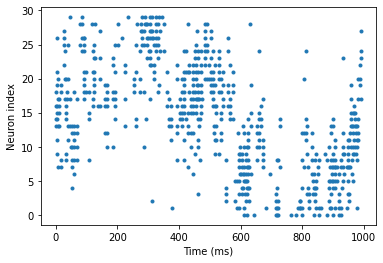

In [8]:
# Plot the results
plt.plot(spikes.t/ms, spikes.i, '.')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index');